# Based on publicly-available data from the city of Charlotte, NC, what venues do most homicides take place near?

### Week 1 Sections: Description of Problem and Data 

#### 1) A description of the problem and a discussion of the background. (15 marks)

The safety of the public is possibly the most visible aspect of the law and order that our government has the responsibility for. Homicide, specifically, is an abrupt punctuation to our otherwise safe lives, far removed from violence in the day to day. Charlotte, as a relatively large US city with one of the highest rates of growth, is a good case to study crime in that it is undergoing rapid socioeconomic transformation and is slightly above average in overall crime rate. 

To tackle the topic of crime rate and data is no small task, so I decided to take a very small chunk and just rank what sort of venues are closest to the recent homicide cases in the city. As will be discussed below, this analysis is so limited that the only insights it should yield are that I learned how to use the Foursquare API and applied a few concepts from this course in its completion.

Thank you for your time.


#### 2) A description of the data and how it will be used to solve the problem. (15 marks)

The primary sources of data for this project are the Charlotte Open Data Portal (https://opencharlotte-charlotte.opendata.arcgis.com/) and the Foursquare API.

The data for the homicides from the Charlotte Open Data Portal contains details about each case, including racial backgrounds and potential motivation, but most importantly for this analysis was simply the location of the crimes as coordinates. 

The biggest task, then, was using the Foursquare API to get nearby venues for each case and categorize them appropriately. Within the API response, the categories listed for each venue are too specific for any meaningful analysis (e.g. 'Shanghai Restaurant' and 'Beijing Restaurant' should both be classified as 'Chinese Restaurant'), so a significant amount of my time was spent trying to figure out how to meaningfully use Foursquare's category hierarchy to recategorize all the venues. 

I ended up just creating the most broad categories - 'Food,' 'Professional & Other Services,' 'Arts and Entertainment,' etc. - in the interest of having meaningful insight with the size of this dataset and not pulling my hair out too much in doing so. 

With the nearby venues' categories for each case, I used very cursory data analysis methods to find which kinds of venues you would be more likely to get murdered near. I employed one-hot encoding and averaged out the cases near each kind of venue, and then created a matrix showing the relative percent chance of murder near two different kinds of venues. Importantly, however, is that these figures are only measured relative to each other and do not take into account the density of different types of venues. 

To give a concrete example, I found that you are over five times as likely to be killed near a restaurant and a store compared with near an office and a college; a very easy criticism of this stat would be that there may be five times as many restaurants and shops as offices and colleges, so the statistic may be meaningless or even harmful in a person's intuition about their safety. On top of this, with only around 500 homicide cases to choose from, several of which happening in the same exact incident, there is little potential for any statistical significance across such a large city no matter what. 

## Import libraries and wrangle/validate data

In [1]:
import pandas as pd
import json
import requests
from pandas import json_normalize
import folium
from sklearn.cluster import KMeans
import seaborn as sns

# this is a list of all categories from the Foursquare API's GET categories hierarchy request
# found in getCategoryHierarchy.ipynb notebook

%store -r smallCatList


In [2]:
homicide_df = pd.read_csv('/Users/jimmy/Downloads/CMPD_Homicide.csv')
homicide_df.head(5)

,X,Y,ID,CRIME_REPORT_ID,AGE,GENDER,RACE_ETHNICITY,CLEARANCE_STATUS,CLEARANCE_DATE,IPV,WEAPON,CIRCUMSTANCES,LOCATION,X_COORD_PUBLIC,Y_COORD_PUBLIC,LATITUDE_PUBLIC,LONGITUDE_PUBLIC,CMPD_PATROL_DIVISION,NPA,OBJECTID
0,1.492596e+06,533772.999904,1,20201224-2245-02,13.0,Female,Hispanic,Open,NaN,NaN,NaN,Other/Unknown,6600 OLDE SAVANNAH RD,1492596.0,533773.0,35.204712,-80.698703,Hickory Grove,146,1
1,1.492596e+06,533772.999904,2,20201224-2245-02,16.0,Female,Hispanic,Open,NaN,NaN,NaN,Other/Unknown,6600 OLDE SAVANNAH RD,1492596.0,533773.0,35.204712,-80.698703,Hickory Grove,146,2
2,1.481528e+06,577152.000000,3,20201223-1934-00,50.0,Female,Black,Open,NaN,NaN,NaN,Other/Unknown,10100 WOODBERRY TRAIL LN,1481528.0,577152.0,35.323358,-80.738292,University City,65,3
3,1.481528e+06,577152.000000,4,20201223-1934-00,59.0,Male,Black,Open,NaN,NaN,NaN,Other/Unknown,10100 WOODBERRY TRAIL LN,1481528.0,577152.0,35.323358,-80.738292,University City,65,4
4,1.464732e+06,529906.000000,5,20201222-2205-01,24.0,Male,Black,Open,NaN,NaN,NaN,Other/Unknown,1100 MCALWAY RD,1464732.0,529906.0,35.192742,-80.791733,Providence,394,5


In [3]:
# Remove unnecessary columns from dataframes and clean things up

homicide_df = homicide_df.drop(columns=['X_COORD_PUBLIC',
                                        'Y_COORD_PUBLIC',
                                        'IPV','CLEARANCE_STATUS',
                                        'X',
                                        'Y', 
                                        'ID',
                                        'CLEARANCE_DATE',
                                        'WEAPON',
                                        'CMPD_PATROL_DIVISION',
                                        'NPA',
                                        'OBJECTID'])


homicide_df.rename(str.lower, axis='columns', inplace=True)

homicide_df.rename(columns={'latitude_public':'crime_latitude', 
                            'longitude_public':'crime_longitude'}, inplace=True)

print(homicide_df.columns)


Index(['crime_report_id', 'age', 'gender', 'race_ethnicity', 'circumstances',
       'location', 'crime_latitude', 'crime_longitude'],
      dtype='object')


In [4]:
# drop missing location values and double-check for any remaining

homicide_df['crime_latitude'].dropna(inplace=True)
homicide_df['crime_longitude'].dropna(inplace=True)

hasLatNan = homicide_df['crime_latitude'].isna()
hasLngNan = homicide_df['crime_longitude'].isna()

print('latitude null values:\n{}\n\nlongitude null values:\n{}'.format(hasLatNan.value_counts(), hasLngNan.value_counts()))

latitude null values:
False    477
Name: crime_latitude, dtype: int64

longitude null values:
False    477
Name: crime_longitude, dtype: int64


In [5]:
# check there aren't any errant values in the range of coordinates, compared with CLT city range per Google

print('Lat min, max: {},{}\nLong min, max {},{}'.format(homicide_df['crime_latitude'].min(),homicide_df['crime_latitude'].max(), homicide_df['crime_longitude'].min(),homicide_df['crime_longitude'].max()))

Lat min, max: 35.03487,35.386306
Long min, max -81.032238,-80.620187


## Create function to find nearby venues for each homicide case

In [6]:
# the only data needed for each case is the crime_report_id, venue name and category, and location of both crime and venue

def getNearbyVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        
        url = 'https://api.foursquare.com/v2/venues/explore'

        # pls ignore this ugliness as I tried to convert lat and lng into strings
        latlng = str(lat) + ',' + str(lng)
        
        
        params = dict(
            client_id = 'FQATKQEFO0CWQSG0GGXEEHPOPQJSFZ4N5T1H2FBZMTKR4CU4',
            client_secret = '2Z5WI2MSN5A54B44OLHURZGWUYNEATSKU5QNGWLIOFEA05H2',
            v = '20180604',
            ll = latlng,
            limit = 50,
            radius = 200
        )

        resp = requests.get(url=url, params=params)
        data = json.loads(resp.text)
        venues=data["response"]['groups'][0]['items']
         


        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venues])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['crime_report_id', 
                  'crime_latitude', 
                  'crime_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(nearby_venues)

In [7]:
# call the function to fill up new dataframe
crimeNearbyVenues = pd.DataFrame()

crimeNearbyVenues = getNearbyVenues(names = homicide_df['crime_report_id'], latitudes=homicide_df['crime_latitude'], longitudes=homicide_df['crime_longitude'])




20201224-2245-02
20201224-2245-02
20201223-1934-00
20201223-1934-00
20201222-2205-01
20201217-2032-01
20201213-1855-00
20201213-0003-01
20201212-1921-04
20201210-0106-02
20201130-2058-00
20201129-2333-04
20201127-0243-02
20201126-2129-00
20201120-1413-03
20201107-2016-04
20201106-1917-00
20201104-1923-01
20201030-2332-00
20201028-0914-08
20201027-1851-02
20201024-0222-03
20201021-2200-01
20201019-1214-02
20201019-1214-02
20201016-0409-00
20201013-0356-02
20201012-1813-00
20201012-1748-03
20201009-2039-02
20201009-0341-00
20201005-2129-01
20201003-0205-00
20201001-1240-03
20200930-1528-00
20200927-2044-00
20200914-1618-04
20200910-0406-02
20200906-1630-00
20200904-2143-00
20200823-0412-01
20200822-1541-00
20200821-1721-04
20200818-0156-05
20200818-0016-01
20200816-2151-04
20200816-2151-04
20200816-2151-04
20200805-1510-02
20200801-1042-04
20200729-1603-03
20200728-1829-01
20200726-0241-02
20200725-2204-02
20200724-2058-01
20200723-0734-00
20200721-1710-00
20200721-1420-07
20200718-0559-

## Recategorize all venues

In [8]:
# using the list of Foursquare categories imported above, created rudimentary broad classifications
arts = smallCatList[0:67]
uni = smallCatList[67:106]
event = smallCatList[106:119]
food = smallCatList[119:477]
nightlife = smallCatList[477:504]
rec = smallCatList[504:616]
pro = smallCatList[616:728]
reside = smallCatList[728:734]
shop = smallCatList[734:913]
travel = smallCatList[913:]

In [9]:
# reclassify categories to broader classifications
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([arts],'Arts & Entertainment')
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([uni],'Colleges & Universities')
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([event],'Events')
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([food],'Food')
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([nightlife],'Nightlife Spot')
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([rec],'Outdoors & Recreation')
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([pro],'Professional & Other Places')
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([reside],'Residence')
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([shop],'Shop & Service')
crimeNearbyVenues['venue_category'] = crimeNearbyVenues['venue_category'].replace([travel],'Travel & Transport')

crimeNearbyVenues['venue_category'].value_counts()

Food                           384
Shop & Service                 333
Outdoors & Recreation           78
Travel & Transport              74
Nightlife Spot                  60
Arts & Entertainment            51
Colleges & Universities          2
Professional & Other Places      1
Residence                        1
Name: venue_category, dtype: int64

## One-hot encoding and employing simple statistical methods

In [10]:
# one-hot based on categories
clt_onehot = pd.get_dummies(crimeNearbyVenues, columns=['venue_category'])
clt_onehot.columns

Index(['crime_report_id', 'crime_latitude', 'crime_longitude', 'venue',
       'venue_latitude', 'venue_longitude',
       'venue_category_Arts & Entertainment',
       'venue_category_Colleges & Universities', 'venue_category_Food',
       'venue_category_Nightlife Spot', 'venue_category_Outdoors & Recreation',
       'venue_category_Professional & Other Places',
       'venue_category_Residence', 'venue_category_Shop & Service',
       'venue_category_Travel & Transport'],
      dtype='object')

In [11]:
# create and clean up clt_grouped, which will be used to average venues nearby to crimes
clt_grouped = clt_onehot.groupby('crime_report_id').mean().reset_index()
clt_grouped = clt_grouped.drop(columns=['crime_report_id', 'crime_latitude', 'crime_longitude',
       'venue_latitude', 'venue_longitude'])

clt_grouped.head(5)

,venue_category_Arts & Entertainment,venue_category_Colleges & Universities,venue_category_Food,venue_category_Nightlife Spot,venue_category_Outdoors & Recreation,venue_category_Professional & Other Places,venue_category_Residence,venue_category_Shop & Service,venue_category_Travel & Transport
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.3,0.1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# create for functions that average out the values

total = 0

averages_df = pd.DataFrame()

for column in clt_grouped.columns:
    a = clt_grouped[column].cumsum()
    value = a.iat[-1]
    total = total + value
    
for column in clt_grouped.columns:
    a = clt_grouped[column].cumsum()
    averages_df.at[column, 'pct_average'] = (a.iat[-1] / total) * 100
    

In [13]:
transposedAvg = averages_df.T

In [14]:
# iterate over pct_average columns and add to list z which becomes dataframe this_df

z = 0
thisList = []
for v in averages_df.pct_average:
    z = averages_df.pct_average + v
    thisList.append(z)

matrix_df = pd.DataFrame(data = thisList)
matrix_df.head()

,venue_category_Arts & Entertainment,venue_category_Colleges & Universities,venue_category_Food,venue_category_Nightlife Spot,venue_category_Outdoors & Recreation,venue_category_Professional & Other Places,venue_category_Residence,venue_category_Shop & Service,venue_category_Travel & Transport
pct_average,13.676491,7.054591,35.175329,11.417352,20.409926,6.902348,7.222861,45.635416,14.049894
pct_average,7.054591,0.432692,28.553430,4.795453,13.788027,0.280449,0.600962,39.013517,7.427995
pct_average,35.175329,28.553430,56.674167,32.916190,41.908765,28.401186,28.721699,67.134254,35.548732
pct_average,11.417352,4.795453,32.916190,9.158213,18.150788,4.643209,4.963722,43.376277,11.790755
pct_average,20.409926,13.788027,41.908765,18.150788,27.143362,13.635784,13.956296,52.368852,20.783330


In [15]:
# I was going to have to deal with the issue of duplicate index values so I sorted them to create a key below

matrix_df.sort_index(axis=1,ascending=False, inplace=True)
matrix_df.sort_values(by='venue_category_Shop & Service', axis=0,ascending=False, inplace=True)

In [16]:
# spaghetti code to differentiate all the duplicated row names

x=0
for index in matrix_df.index:
    x = x+1
    matrix_df.index = matrix_df.index.where(~matrix_df.index.duplicated(), matrix_df.index + str(x))

In [17]:
matrix_df

,venue_category_Travel & Transport,venue_category_Shop & Service,venue_category_Residence,venue_category_Professional & Other Places,venue_category_Outdoors & Recreation,venue_category_Nightlife Spot,venue_category_Food,venue_category_Colleges & Universities,venue_category_Arts & Entertainment
pct_average,46.008819,77.594341,39.181786,38.861273,52.368852,43.376277,67.134254,39.013517,45.635416
pct_average1,35.548732,67.134254,28.721699,28.401186,41.908765,32.916190,56.674167,28.553430,35.175329
pct_average12,20.783330,52.368852,13.956296,13.635784,27.143362,18.150788,41.908765,13.788027,20.409926
pct_average123,14.423298,46.008819,7.596264,7.275751,20.783330,11.790755,35.548732,7.427995,14.049894
pct_average1234,14.049894,45.635416,7.222861,6.902348,20.409926,11.417352,35.175329,7.054591,13.676491
pct_average12345,11.790755,43.376277,4.963722,4.643209,18.150788,9.158213,32.916190,4.795453,11.417352
pct_average123456,7.596264,39.181786,0.769231,0.448718,13.956296,4.963722,28.721699,0.600962,7.222861
pct_average1234567,7.427995,39.013517,0.600962,0.280449,13.788027,4.795453,28.553430,0.432692,7.054591
pct_average12345678,7.275751,38.861273,0.448718,0.128205,13.635784,4.643209,28.401186,0.280449,6.902348


In [18]:
#the pct_average renamings are based on having sorted the indexes in descending order

matrix_df = matrix_df.rename({'pct_average':'Shop & Service', 'pct_average1':'Food',
                          'pct_average12':'Outdoors & Recreation', 'pct_average123':'Nightlife Spot',
                          'pct_average1234':'Travel & Transport', 'pct_average12345':'Residence', 
                          'pct_average123456':'Colleges & Universities',
                          'pct_average1234567':'Shop & Service', 
                          'pct_average12345678':'Professional & Other Places'}, axis='index')

matrix_df = matrix_df.rename({'venue_category_Shop & Service':'Shop & Service', 'venue_category_Food':'Food',
                          'venue_category_Outdoors & Recreation':'Outdoors & Recreation', 
                          'venue_category_Travel & Transport':'Travel & Transportation', 
                          'venue_category_Arts & Entertainment':'Arts & Entertainment', 
                          'venue_category_Nightlife Spot':'Nightlife Spot', 'venue_category_Residence':'Residence', 
                          'venue_category_Colleges & Universities':'Colleges & Universities', 
                          'venue_category_Professional & Other Places':'Professional & Other Places'}, axis='columns')

matrix_df.head(10)

,Travel & Transportation,Shop & Service,Residence,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Food,Colleges & Universities,Arts & Entertainment
Shop & Service,46.008819,77.594341,39.181786,38.861273,52.368852,43.376277,67.134254,39.013517,45.635416
Food,35.548732,67.134254,28.721699,28.401186,41.908765,32.916190,56.674167,28.553430,35.175329
Outdoors & Recreation,20.783330,52.368852,13.956296,13.635784,27.143362,18.150788,41.908765,13.788027,20.409926
Nightlife Spot,14.423298,46.008819,7.596264,7.275751,20.783330,11.790755,35.548732,7.427995,14.049894
Travel & Transport,14.049894,45.635416,7.222861,6.902348,20.409926,11.417352,35.175329,7.054591,13.676491
Residence,11.790755,43.376277,4.963722,4.643209,18.150788,9.158213,32.916190,4.795453,11.417352
Colleges & Universities,7.596264,39.181786,0.769231,0.448718,13.956296,4.963722,28.721699,0.600962,7.222861
Shop & Service,7.427995,39.013517,0.600962,0.280449,13.788027,4.795453,28.553430,0.432692,7.054591
Professional & Other Places,7.275751,38.861273,0.448718,0.128205,13.635784,4.643209,28.401186,0.280449,6.902348


## Visualizations
### Heatmap

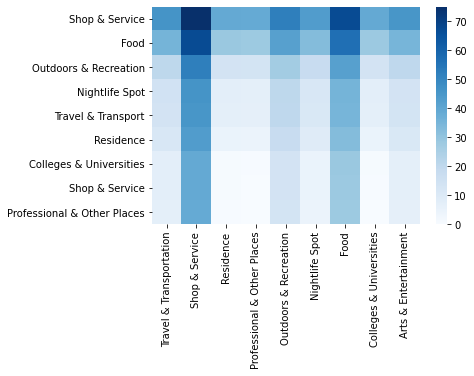

In [19]:
# heat map where the darker the blue, the more likely that the two venues are both near a murder
snsMap = sns.heatmap(matrix_df, cbar=True, vmin=0,vmax=75, cmap="Blues")

### Map

The aim here is to create a map that shows incidents as circles with an area the same size as what we used to search for venues. If you click on these circles you can access data relating to the crime, such as victim age, ethnicity, circumstances, etc. Then, using another layer, plot on the venues within each circle. If you click on the venues, you can get things like the venue category and name.

In [20]:
cltMap = folium.Map(location=[35.2236, -80.8450], tiles="Stamen Toner")

In [21]:
# NOTE: two victims killed in the same incident appears to be a single incident on this map

# narrMsg will be displayed if you click on the red area circles indicating the crimes
narrMsg = 'Victim: Age: {}, Gender: {}, Race/Ethnicity: {}, Circumstances: {}, Address of Crime: {}'


cltMap = folium.Map(location=[35.2236, -80.8450], tiles="Stamen Toner")
featureGroup_shootings = folium.FeatureGroup(name='shootings')
featureGroup_shootingsOdd = folium.FeatureGroup(name='shootingsOdd')



for index in homicide_df.index[0:476]:
    
    
    lat = homicide_df.at[index,'crime_latitude']
    lng = homicide_df.at[index,'crime_longitude']
    narr = narrMsg.format(homicide_df.at[index,'age'],
                         homicide_df.at[index,'gender'],
                         homicide_df.at[index,'race_ethnicity'],
                         homicide_df.at[index,'circumstances'],
                         homicide_df.at[index,'location'])
    
   
    
    
    
#using Folium Circle because it's radius is in terms of meters, so I can match it with radius used to find venues
#folium circle feature seems to have a limit on objects it can draw, so I set a limit at 200

    featureGroup_shootings.add_child(folium.Circle(
        location=[lat, lng],
        radius=200,
        popup=narr,
        color="red",
        fill=True,
        fill_color="lightred"))


    



cltMap = cltMap.add_child(featureGroup_shootings)



In the below Folium feature group displaying nearby venues, there were some errant venues returned and plotted onto the map as well as some that were missed out on. If this were a more serious project, this would be worthy of troubleshooting.

In [22]:
venueLayer = folium.FeatureGroup()
narrMsg = 'Venue: {}, Venue Category: {}'
for index in crimeNearbyVenues.index:
    
    
    lat = crimeNearbyVenues.at[index,'venue_latitude']
    lng = crimeNearbyVenues.at[index,'venue_longitude']
    narr = narrMsg.format(crimeNearbyVenues.at[index,'venue'],
                         crimeNearbyVenues.at[index,'venue_category'])
    
    
# using Folium Circle because it's radius is in terms of meters, so I can match it with radius used to find venues
# folium circle feature seems to have a limit on objects it can draw, so I set a limit at 200

    folium.CircleMarker(
        location=[lat, lng],
        popup=narr,
        color="blue",
        radius=2,
        fill=True,
        fill_color="#3186cc",).add_to(venueLayer)

    
venueLayer.add_to(cltMap)

In [23]:
cltMap

In [24]:
cltMap.save("index.html")